### Load libraries

In [1]:
import dataclasses
from typing import Collection

import matplotlib.pyplot as plt
import numpy as np
import scipy.special
import scipy.stats
from tqdm.auto import tqdm

plt.style.use('ggplot')

### Helper functions

In [53]:
def get_err(n_train: int, d: int, sep: float) -> float:
    w0 = np.abs(sep + np.random.normal(size=n_train)).mean()
    w1 = np.sqrt(scipy.stats.chi2.rvs(d - 1) / n_train)
    # TODO(tony): sample w1 faster

    norm = np.linalg.norm([w0, w1])
    w0 /= norm
    w1 /= norm

    def get_prob(m1: float, m2: float, c12: float) -> float:
        """
        Returns P(A > 0 and B <= 0) + P(A <= 0 and B > 0)
        assuming [A, B] ~ N([m1, m2], [[1, c12], [c12, 1]])
        """
        prob0: float = scipy.stats.multivariate_normal(
            mean=(-m1, m2),
            cov=((1, -c12), (-c12, 1)),  # type: ignore
        ).cdf(np.zeros(2))

        prob1: float = scipy.stats.multivariate_normal(
            mean=(m1, -m2),
            cov=((1, -c12), (-c12, 1)),  # type: ignore
        ).cdf(np.zeros(2))

        return prob0 + prob1

    return (get_prob(sep, sep * w0, w0) + get_prob(-sep, -sep * w0, w0)) / 2

### Scaling experiments

In [54]:
@dataclasses.dataclass
class ScalingResult:
    d: int
    sep: float
    n_trains: np.ndarray
    
    err_stack: np.ndarray

    def __post_init__(self):
        n, = self.n_trains.shape
        assert self.err_stack.shape[1] == n

    def plot(self, **kwargs):
        lo = np.quantile(self.err_stack, q=0.05, axis=0)
        mid = np.quantile(self.err_stack, q=0.5, axis=0)
        hi = np.quantile(self.err_stack, q=0.95, axis=0)
        
        p = plt.plot(self.n_trains, mid, label=f"sep={self.sep}")
        plt.fill_between(
            x=self.n_trains,
            y1=lo,
            y2=hi,
            alpha=0.25,
            color=p[0].get_color(),
        )



def run_exp(
    n_trains_raw: Collection[int],
    d: int,
    sep: float,
    n_trials: int = 100,
) -> ScalingResult:
    n_trains: np.ndarray = np.array(sorted(list(set(n_trains_raw))))

    err_stack = np.zeros((n_trials, len(n_trains)))

    for i in tqdm(range(n_trials)):
        for j, n in enumerate(n_trains):
            err_stack[i, j] = get_err(
                n_train=n, d=d, sep=sep
            )

    return ScalingResult(
        d=d,
        sep=sep,
        n_trains=n_trains,
        err_stack=err_stack
    )

In [55]:
RES = {}

In [56]:
for sep in [0, 1, 2, 3, 5, 6]:
    if sep not in RES:
        RES[sep] = run_exp(
            n_trains_raw=list(range(2, 100)) + [2**i for i in range(1, 20)],
            d=1000,
            sep=sep,
            n_trials=50,
        )

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

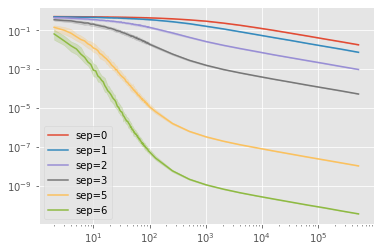

In [51]:
for sep in [0, 1, 2, 3, 5, 6]:
    RES[sep].plot()

plt.xscale("log")
plt.yscale("log")
plt.legend();